# Problem 2

I refer Chapter 5 codes, sourced from our main teaching site http://www.math.snu.ac.kr/~ernestryu/courses/deep_learning.html.  
Import necessary modules and parameters.  
Here we use target distribution as standard normal distribution $\mathcal{N}(0,1)$, instead of uniform. We must modify it.

In [1]:
import torch
import torch.utils.data as data 
import torch.nn as nn
from torch.distributions.normal import Normal 
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt


epochs = 50
learning_rate = 5e-3
batch_size = 128
n_components = 5 # the number of kernel
target_distribution = Normal(0.0, 1.0)

Also, $f_\theta$ is different from source. Expressions of $f_\theta$, $f_\theta$' in forward step is modified.

In [2]:
class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logs = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logs.view(1,-1).exp()
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = ((distribution.cdf(x)-0.5) * weights).sum(dim=1)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx

We use same dataset and datasets, and loss function defined by log-likelihood.

In [3]:
def mixture_of_gaussians(num, mu_var=(-1,0.25, 0.2,0.25, 1.5,0.25)):
    n = num // 3
    m1,s1,m2,s2,m3,s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num-n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])



class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

In [4]:
def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  #flip sign, and sum of data X_1,...X_N

Now we train and test model.

In [5]:
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
    # flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss/(i+1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss/(i+1))

Followings are results.  

First, as we set, distribution of data looks closed to mixture Gaussian.

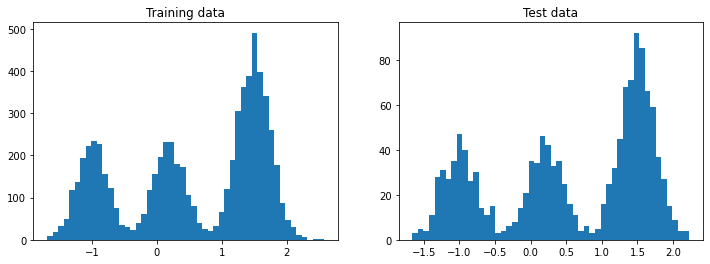

In [6]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Test data')

Next figures reflects out training, and test step.  
As you see, it works well.

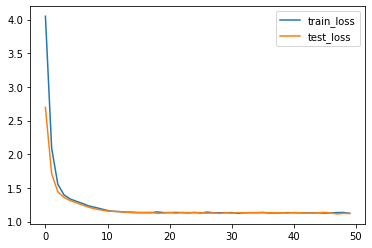

In [7]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

Finally, below figures are visualization of $f_\theta$.

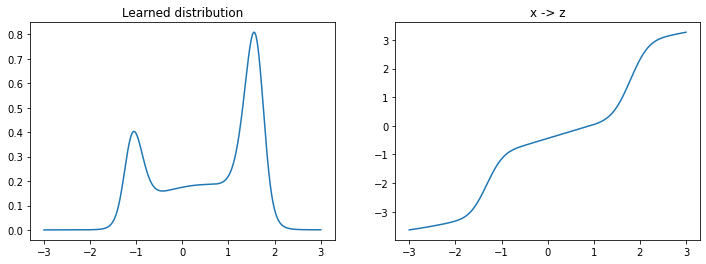

In [8]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

We must check whether $f_\theta$ preserves expected distribution of $z$, defined initially.  
Although there are some defects near mean, overall shape is similar to expected standard normal distribution.

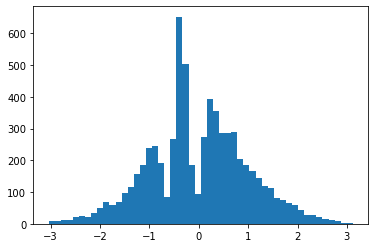

In [9]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    
_ = plt.hist(np.array(z), bins=50)